In [1]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
""" Read data to be used """
# In this example, a dataset about spamming is used
data = pd.read_csv('spambase.csv',sep=",")
data.head()

""" Some preprocessing on data """
# Number of features
m = data.shape[1]
# Remove unwanted features
X = data.iloc[:,0:48]
y = data.iloc[:,(m-1):]

# Turn data into onehot format
X_onehot = pd.get_dummies(X)

In [3]:
from sklearn.model_selection import train_test_split
""" Splitting training and testing data """
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.25, random_state=33)

In [4]:
print("% of spams (train): ", np.mean(y_train))
print("% of spams (test): ", np.mean(y_test))

% of spams (train):  Spam    0.402899
dtype: float64
% of spams (test):  Spam    0.367507
dtype: float64


In [5]:
""" Import BRF classifiers """
from BoostedRandomForest import BoostedRandomForest
# Example usage
#brf = BoostedRandomForest()
#rf = BoostedRandomForest(weight_update=False, boosting=False)
#brf_wout_update = BoostedRandomForest(weight_update=False)

In [6]:
""" Default parameters """
# Max number of trees
brf_params = {'T': 250,
              'depth_max': 20,
              'weight_update': True,
              'boosting': True,
             }


In [53]:
""" Without Early Stopping """
brf_nonstop_params = brf_params
brf_nonstop_clf = BoostedRandomForest(**brf_nonstop_params)

In [54]:
brf_nonstop_clf.fit(X_train, y_train)

In [55]:
# Training accuracies 
brf_train_accs = brf_nonstop_clf.train_accs
print(len(brf_train_accs))
# Epsilons
brf_eps = brf_nonstop_clf.all_eps
print(len(brf_eps))
# Alphas
brf_alphas = brf_nonstop_clf.all_alphas
print(len(brf_alphas))

250
250
250


In [38]:
""" Early Stopping with eps=[1e-20, 0.5]"""
brf_es_params = brf_params
brf_es_params['eps_ub'] = 0.5
brf_es_params['eps_lb'] = 1e-20
brf_es_params['eps_exceed_limit'] = 5
# Disable for evaluate performance after early stopping
brf_es_params['early_stop'] = False 

brf_es_clf = BoostedRandomForest(**brf_es_params)

In [39]:
brf_es_clf.fit(X_train, y_train)

In [40]:
# Training accuracies 
brf_train_accs = brf_es_clf.train_accs
print("Len of accs: ", len(brf_train_accs))
# Ids of saved tress
brf_clf_ids = brf_es_clf.clf_ids
print("Len of ids: ", len(brf_clf_ids))
# Epsilons
brf_eps = brf_es_clf.all_eps
print("Len of eps: ", len(brf_eps))
# Alphas
brf_alphas = brf_es_clf.all_alphas
print("Len of alphs: ", len(brf_alphas))

stop_index = brf_es_clf.stop_index
print("Stop index: ", stop_index)

Len of accs:  250
Len of ids:  250
Len of eps:  250
Len of alphs:  250
Stop index:  -1


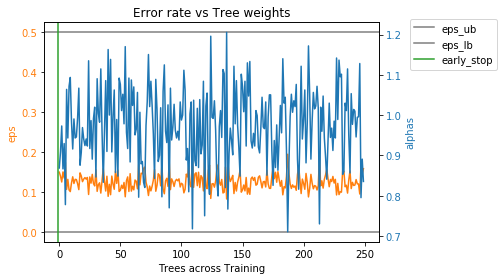

In [56]:
fig1, ax1 = plt.subplots()
plt.title("Error rate vs Tree weights")
ax1.set_xlabel('Trees across Training')

# Epsilons
color = 'tab:orange'
ax1.set_ylabel('eps', color=color)
ax1.plot(brf_eps, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
# Alphas
color = 'tab:blue'
ax2.set_ylabel('alphas', color=color)  
ax2.plot(brf_alphas, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Epsilon limits
color = "tab:grey"
ax1.axhline(y=brf_es_params['eps_ub'], color=color, label="eps_ub")
ax1.axhline(y=brf_es_params['eps_lb'], color=color, label="eps_lb")

# Early stop
color = 'tab:green'
ax1.axvline(x=stop_index, color=color, label="early_stop")

ax1.legend(loc='center right', bbox_to_anchor=(1.37, 0.9))
plt.subplots_adjust(right=0.4)
fig1.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

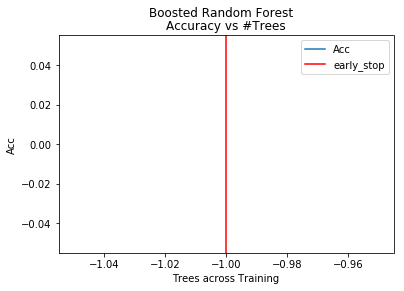

In [ ]:
fig, ax1 = plt.subplots()
plt.suptitle("Boosted Random Forest")
plt.title("Accuracy vs #Trees")
ax1.set_xlabel('Trees across Training')

# Accuracy
color = 'tab:blue'
ax1.set_ylabel('Acc')  
ax1.plot(brf_train_accs, color=color, label="Acc")
ax1.tick_params(axis='y')

# Early stop
color = 'red'
plt.axvline(x=stop_index, color=color, label="early_stop")

plt.legend()
plt.show()


In [7]:
""" Mean performance without early stop """
brf_ns_mean_params = brf_params

In [8]:
brf_ns_accs = []
brf_ns_tree_cnts = []
brf_ns_times = []

loop_start = time()
# Take mean performance from 20 trials
for it in range(20) :
    print("Iteration: ", it)
    # Create new classifier
    brf_ns_mean_clf = BoostedRandomForest(**brf_ns_mean_params)
    
    # Train classifier
    start =  time()
    brf_ns_mean_clf.fit(X_train, y_train)
    end = time()
    
    # Record results
    brf_ns_accs.append(brf_ns_mean_clf.train_accs)
    brf_ns_tree_cnts.append(len(brf_ns_mean_clf.clfs))
    brf_ns_times.append(end-start)
    
    print("Time used from start: ", time()-loop_start)
    

Iteration:  0
Time used from start:  53.014426708221436
Iteration:  1
Time used from start:  116.91923308372498
Iteration:  2
Time used from start:  170.87113666534424
Iteration:  3
Time used from start:  214.71389484405518
Iteration:  4
Time used from start:  272.7438337802887
Iteration:  5
Time used from start:  325.117648601532
Iteration:  6
Time used from start:  377.08522391319275
Iteration:  7
Time used from start:  427.6465799808502
Iteration:  8
Time used from start:  478.48918056488037
Iteration:  9
Time used from start:  536.8159863948822
Iteration:  10
Time used from start:  584.4242851734161
Iteration:  11
Time used from start:  637.0793449878693
Iteration:  12
Time used from start:  687.656325340271
Iteration:  13
Time used from start:  741.1863644123077
Iteration:  14
Time used from start:  804.6849303245544
Iteration:  15
Time used from start:  860.1211750507355
Iteration:  16
Time used from start:  904.4014239311218
Iteration:  17
Time used from start:  954.744034767150

In [9]:
# Find out forest with fewest tree
brf_ns_min_tree_cnt = min(brf_ns_tree_cnts)
print("Min #Tree: ", brf_ns_min_tree_cnt)

brf_ns_mean_tree_cnt = np.mean(brf_ns_tree_cnts)
print("Mean #Tree: ", brf_ns_mean_tree_cnt)

brf_ns_mean_time = np.mean(brf_ns_times)
print("Mean time used: ", brf_ns_mean_time)

# Trim records by min_tree_cnt
trimmed_accs = [ accs[:brf_ns_min_tree_cnt] for accs in brf_ns_accs ]
brf_ns_mean_accs = np.mean(trimmed_accs, axis=0)

print(brf_ns_mean_accs)


Min #Tree:  180
Mean #Tree:  196.25
Mean time used:  52.92614704370499
[0.87291304 0.89268116 0.92430435 0.93153623 0.94266667 0.94623188
 0.95271014 0.95694203 0.96224638 0.96263768 0.9663913  0.96789855
 0.96814493 0.96969565 0.97057971 0.97262319 0.97194203 0.96952174
 0.97313043 0.97191304 0.97244928 0.97423188 0.97431884 0.97584058
 0.97608696 0.97601449 0.97608696 0.97602899 0.97586957 0.97604348
 0.9757971  0.97575362 0.97566667 0.97552174 0.97555072 0.97488406
 0.97491304 0.97463768 0.97450725 0.97443478 0.97397101 0.97363768
 0.97368116 0.97363768 0.97288406 0.97263768 0.97250725 0.97228986
 0.97201449 0.97197101 0.97189855 0.97156522 0.97101449 0.97082609
 0.97076812 0.97031884 0.96997101 0.96986957 0.96923188 0.96910145
 0.96894203 0.96850725 0.96830435 0.968      0.96746377 0.96734783
 0.96710145 0.96678261 0.96656522 0.96642029 0.96608696 0.96565217
 0.96550725 0.96498551 0.96462319 0.96449275 0.96391304 0.96336232
 0.96327536 0.96295652 0.96252174 0.96204348 0.96184058 0.

In [37]:
# Pad accuracy list to length of depth_max
padded_brf_ns_mean_accs = np.hstack([brf_ns_mean_accs, np.array([-1]*(250-brf_ns_min_tree_cnt))])

# Output to csv 
brf_ns_mean_accs_df = pd.DataFrame(padded_brf_ns_mean_accs)
brf_ns_mean_accs_df.to_csv("Results/brf_ns_mean_accs.csv", index=False)

In [11]:
""" Mean performance with early stop """
brf_es_mean_params = brf_params
brf_es_mean_params['eps_ub'] = 0.5
brf_es_mean_params['eps_lb'] = 1e-20
brf_es_mean_params['eps_exceed_limit'] = 5
# Enable early stopping
brf_es_mean_params['early_stop'] = True

In [12]:
brf_es_accs = []
brf_es_tree_cnts = []
brf_es_times = []

loop_start = time()
# Take mean performance from 20 trials
for it in range(20) :
    print("Iteration: ", it)
    # Create new classifier 
    brf_es_mean_clf = BoostedRandomForest(**brf_es_mean_params)
    
    # Train classifier
    start =  time()
    brf_es_mean_clf.fit(X_train, y_train)
    end = time()
    
    # Record results
    brf_es_accs.append(brf_es_mean_clf.train_accs)
    brf_es_tree_cnts.append(len(brf_es_mean_clf.clfs))
    brf_es_times.append(end-start)
    
    print("Time used from start: ", time()-loop_start)
    

Iteration:  0
Time used from start:  1.6874613761901855
Iteration:  1
Time used from start:  5.499875783920288
Iteration:  2
Time used from start:  11.01537537574768
Iteration:  3
Time used from start:  19.04644465446472
Iteration:  4
Time used from start:  22.76510977745056
Iteration:  5
Time used from start:  34.264851093292236
Iteration:  6
Time used from start:  37.014787912368774
Iteration:  7
Time used from start:  40.23346471786499
Iteration:  8
Time used from start:  43.63963747024536
Iteration:  9
Time used from start:  50.9207239151001
Iteration:  10
Time used from start:  55.5768678188324
Iteration:  11
Time used from start:  57.71744465827942
Iteration:  12
Time used from start:  59.85802173614502
Iteration:  13
Time used from start:  62.99857568740845
Iteration:  14
Time used from start:  71.68587851524353
Iteration:  15
Time used from start:  75.68578886985779
Iteration:  16
Time used from start:  79.21695828437805
Iteration:  17
Time used from start:  80.90441989898682
I

In [13]:
# Find out forest with fewest tree
brf_es_min_tree_cnt = min(brf_es_tree_cnts)
print("Min #Tree: ", brf_es_min_tree_cnt)

brf_es_mean_tree_cnt = np.mean(brf_es_tree_cnts)
print("Mean #Tree: ", brf_es_mean_tree_cnt)

brf_es_mean_time = np.mean(brf_es_times)
print("Mean time used: ", brf_es_mean_time)

# Trim records by min_tree_cnt
trimmed_accs = [ accs[:brf_es_min_tree_cnt] for accs in brf_es_accs ]
brf_es_mean_accs = np.mean(trimmed_accs, axis=0)

print(brf_es_mean_accs)



Min #Tree:  32
Mean #Tree:  57.5
Mean time used:  4.404587936401367
[0.86856522 0.89114493 0.92321739 0.93247826 0.94468116 0.94591304
 0.95324638 0.95601449 0.96002899 0.96255072 0.96482609 0.96653623
 0.96878261 0.96891304 0.96950725 0.97018841 0.97097101 0.97169565
 0.97337681 0.97224638 0.97272464 0.97447826 0.97307246 0.97462319
 0.97307246 0.97217391 0.97353623 0.97369565 0.97507246 0.97518841
 0.97544928 0.97542029]


In [35]:
# Pad accuracy list to length of depth_max
padded_brf_es_mean_accs = np.hstack([brf_es_mean_accs, np.array([-1]*(250-brf_es_min_tree_cnt))])

# Output to csv 
brf_es_mean_accs_df = pd.DataFrame(padded_brf_es_mean_accs)
brf_es_mean_accs_df.to_csv("Results/brf_es_mean_accs.csv", index=False)

In [15]:
""" Mean performance without weight updates without early stop """
brf_wout_update_mean_params = brf_params
brf_wout_update_mean_params['eps_ub'] = 0.5
brf_wout_update_mean_params['eps_lb'] = 1e-20
brf_wout_update_mean_params['eps_exceed_limit'] = 5
# Disable early stopping
brf_wout_update_mean_params['early_stop'] = False
# Without weight update
brf_wout_update_mean_params['weight_update'] = False
brf_wout_update_mean_params['boosting'] = True

In [16]:
brf_wout_updates_acc = []
brf_wout_updates_tree_cnt = []
brf_wout_updates_time = []

loop_start = time()
# Take mean performance from 20 trials
for it in range(20) :
    print("Iteration: ", it)
    # Create new classifier 
    brf_wout_update_mean_clf = BoostedRandomForest(**brf_wout_update_mean_params)
    
    # Train classifier
    start =  time()
    brf_wout_update_mean_clf.fit(X_train, y_train)
    end = time()
    
    # Record results
    brf_wout_update_accs.append(brf_wout_update_mean_clf.train_accs)
    brf_wout_update_tree_cnts.append(len(brf_wout_update_mean_clf.clfs))
    brf_wout_update_times.append(end-start)
    
    print("Time used from start: ", time()-loop_start)
    

Iteration:  0
Time used from start:  90.81044673919678
Iteration:  1
Time used from start:  181.74589014053345
Iteration:  2
Time used from start:  272.63445949554443
Iteration:  3
Time used from start:  363.5230312347412
Iteration:  4
Time used from start:  454.6303446292877
Iteration:  5
Time used from start:  545.6595375537872
Iteration:  6
Time used from start:  636.6106059551239
Iteration:  7
Time used from start:  727.6397957801819
Iteration:  8
Time used from start:  818.62211561203
Iteration:  9
Time used from start:  909.6200563907623
Iteration:  10
Time used from start:  1000.7429950237274
Iteration:  11
Time used from start:  1092.4752962589264
Iteration:  12
Time used from start:  1183.77010679245
Iteration:  13
Time used from start:  1274.705549955368
Iteration:  14
Time used from start:  1369.015916109085
Iteration:  15
Time used from start:  1463.6544034481049
Iteration:  16
Time used from start:  1557.0272908210754
Iteration:  17
Time used from start:  1650.681423187255

In [17]:
# Find out forest with fewest tree
brf_wout_update_min_tree_cnt = min(brf_wout_update_tree_cnts)
print("Min #Tree: ", brf_wout_updates_min_tree_cnt)

brf_wout_update_mean_tree_cnt = np.mean(brf_wout_update_tree_cnts)
print("Mean #Tree: ", brf_wout_update_mean_tree_cnt)

brf_wout_update_mean_time = np.mean(brf_wout_update_times)
print("Mean time used: ", brf_wout_update_mean_time)

# Trim records by min_tree_cnt
trimmed_accs = [ accs[:brf_wout_update_min_tree_cnt] for accs in brf_wout_update_accs ]
brf_wout_update_mean_accs = np.mean(trimmed_accs, axis=0)

print("Max acc: ", max(brf_wout_update_mean_accs))
print(brf_wout_update_mean_accs)

Min #Tree:  250
Mean #Tree:  250.0
Mean time used:  91.92604638338089
Max acc:  0.9631449275362318
[0.87369565 0.89724638 0.91942029 0.93004348 0.93842029 0.94162319
 0.94523188 0.94724638 0.94969565 0.95046377 0.95213043 0.95298551
 0.95349275 0.95405797 0.95457971 0.95507246 0.95589855 0.95668116
 0.95708696 0.95771014 0.95784058 0.95850725 0.95833333 0.95881159
 0.95865217 0.95872464 0.95898551 0.95914493 0.95968116 0.95973913
 0.95997101 0.95978261 0.96021739 0.96002899 0.9603913  0.96057971
 0.96069565 0.96089855 0.96097101 0.96111594 0.96094203 0.96089855
 0.96101449 0.96127536 0.96163768 0.96133333 0.96175362 0.96134783
 0.9615942  0.96149275 0.96130435 0.96155072 0.96168116 0.96172464
 0.96153623 0.9616087  0.96175362 0.96181159 0.9616087  0.96182609
 0.96184058 0.96175362 0.96181159 0.96157971 0.96175362 0.96165217
 0.96188406 0.96163768 0.96165217 0.96169565 0.96175362 0.96168116
 0.96175362 0.96168116 0.96185507 0.96204348 0.96221739 0.96192754
 0.96223188 0.96215942 0.96210

In [25]:
# Output to csv 
brf_wout_update_mean_accs_df = pd.DataFrame(brf_wout_update_mean_accs)
brf_wout_update_mean_accs_df.to_csv("Results/brf_wout_update_mean_accs.csv", index=False)

In [18]:
""" Mean performane with RF """
brf_rf_mean_params = brf_params
brf_rf_mean_params['eps_ub'] = 0.5
brf_rf_mean_params['eps_lb'] = 1e-20
brf_rf_mean_params['eps_exceed_limit'] = 5
# Disable early stopping
brf_rf_mean_params['early_stop'] = False
# RF
brf_rf_mean_params['weight_update'] = False
brf_rf_mean_params['boosting'] = False

In [19]:
brf_rf_accs = []
brf_rf_tree_cnts = []
brf_rf_times = []

loop_start = time()
# Take mean performance from 20 trials
for it in range(20) :
    print("Iteration: ", it)
    # Create new classifier 
    brf_rf_mean_clf = BoostedRandomForest(**brf_rf_mean_params)
    
    # Train classifier
    start =  time()
    brf_rf_mean_clf.fit(X_train, y_train)
    end = time()
    
    # Record results
    brf_rf_accs.append(brf_rf_mean_clf.train_accs)
    brf_rf_tree_cnts.append(len(brf_rf_mean_clf.clfs))
    brf_rf_times.append(end-start)
    
    print("Time used from start: ", time()-loop_start)
    

Iteration:  0
Time used from start:  92.70102977752686
Iteration:  1
Time used from start:  183.24585723876953
Iteration:  2
Time used from start:  273.19694781303406
Iteration:  3
Time used from start:  363.33553528785706
Iteration:  4
Time used from start:  454.8022155761719
Iteration:  5
Time used from start:  546.0501525402069
Iteration:  6
Time used from start:  636.5012309551239
Iteration:  7
Time used from start:  727.4054262638092
Iteration:  8
Time used from start:  819.9033348560333
Iteration:  9
Time used from start:  910.5887839794159
Iteration:  10
Time used from start:  1000.1648843288422
Iteration:  11
Time used from start:  1089.60036110878
Iteration:  12
Time used from start:  1178.9733407497406
Iteration:  13
Time used from start:  1268.2213220596313
Iteration:  14
Time used from start:  1357.3911802768707
Iteration:  15
Time used from start:  1447.1235270500183
Iteration:  16
Time used from start:  1536.1527643203735
Iteration:  17
Time used from start:  1624.9007582

In [20]:
# Find out forest with fewest tree
brf_rf_min_tree_cnt = min(brf_rf_tree_cnts)
print("Min #Tree: ", brf_rf_min_tree_cnt)

brf_rf_mean_tree_cnt = np.mean(brf_rf_tree_cnts)
print("Mean #Tree: ", brf_rf_mean_tree_cnt)

brf_rf_mean_time = np.mean(brf_rf_times)
print("Mean time used: ", brf_rf_mean_time)

# Trim records by min_tree_cnt
trimmed_accs = [ accs[:brf_rf_min_tree_cnt] for accs in brf_rf_accs ]
brf_rf_mean_accs = np.mean(trimmed_accs, axis=0)

print("Max acc: ", max(brf_rf_mean_accs))
print(brf_rf_mean_accs)



Min #Tree:  250
Mean #Tree:  250.0
Mean time used:  90.17061719894409
Max acc:  0.9627826086956522
[0.87469565 0.89030435 0.91956522 0.92731884 0.93795652 0.94017391
 0.94528986 0.94755072 0.94852174 0.95002899 0.95065217 0.95188406
 0.95326087 0.95330435 0.95511594 0.95510145 0.95518841 0.9554058
 0.95576812 0.9565942  0.95669565 0.95731884 0.95778261 0.95785507
 0.95784058 0.95862319 0.9583913  0.95850725 0.95891304 0.95917391
 0.95907246 0.95942029 0.95989855 0.95927536 0.95956522 0.9595942
 0.95966667 0.95982609 0.96017391 0.96001449 0.96010145 0.96030435
 0.96023188 0.96014493 0.96068116 0.96110145 0.96086957 0.96078261
 0.96094203 0.96107246 0.9612029  0.961      0.96104348 0.96104348
 0.96113043 0.96117391 0.96123188 0.96113043 0.96108696 0.96113043
 0.96123188 0.96111594 0.96126087 0.96124638 0.96111594 0.961
 0.96101449 0.96124638 0.96115942 0.96095652 0.96114493 0.96117391
 0.96107246 0.96134783 0.96128986 0.96114493 0.96130435 0.96128986
 0.96133333 0.9615942  0.96146377 0.9

In [22]:
# Output to csv 
brf_rf_mean_accs_df = pd.DataFrame(brf_rf_mean_accs)
brf_rf_mean_accs_df.to_csv("Results/brf_rf_mean_accs.csv", index=False)

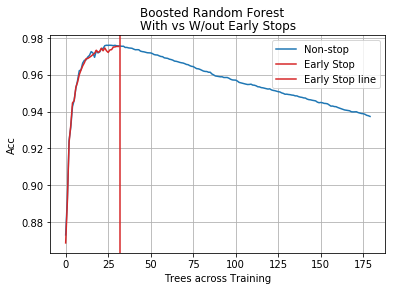

In [47]:
""" Plot: With vs W/Out Early Stopping  """
fig1, ax1 = plt.subplots()
plt.suptitle("Boosted Random Forest")
plt.title("With vs W/out Early Stops")
ax1.set_xlabel('Trees across Training')
ax1.set_ylabel('Acc')  
ax1.tick_params(axis='y')

# Nonstop
color = 'tab:blue'
ax1.plot(brf_ns_mean_accs, color=color, label="Non-stop")


# Early Stop
color = 'tab:red'
ax1.plot(brf_es_mean_accs, color=color, label="Early Stop")
color = 'tab:red'
plt.axvline(x=brf_es_min_tree_cnt, color=color, label="Early Stop line")

plt.grid()
plt.legend()
plt.show()

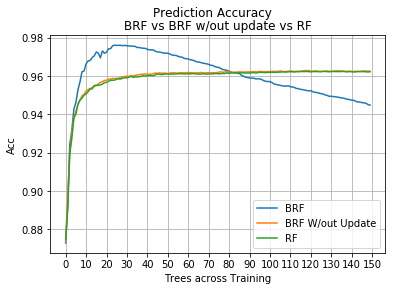

In [46]:
""" Plot: BRF vs BRF w/out update vs RF  """
num_Tree = 150

fig2, ax1 = plt.subplots()
plt.suptitle("Prediction Accuracy")
plt.title("BRF vs BRF w/out update vs RF")
ax1.set_xlabel('Trees across Training')
ax1.set_ylabel('Acc')  
ax1.tick_params(axis='y')
ax1.set_xticks(list(range(0, num_Tree+1, 10)))

# BRF
color = 'tab:blue'
ax1.plot(brf_ns_mean_accs[:num_Tree], color=color, label="BRF")
# W/out weight update
color = 'tab:orange'
ax1.plot(brf_wout_updates_mean_accs[:num_Tree], color=color, label="BRF W/out Update")
# RF
color = 'tab:green'
ax1.plot(brf_rf_mean_accs[:num_Tree], color=color, label="RF")


plt.grid()
plt.legend()
plt.show()

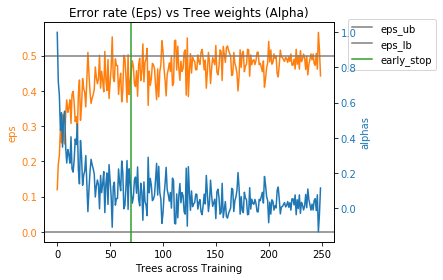

In [59]:
""" Plot: Epsilons vs Alphas """

# Error rates
brf_ns_eps = brf_ns_mean_clf.all_eps
# Alpha
brf_ns_alphas = brf_ns_mean_clf.all_alphas
# Stop index
brf_es_stop_index = brf_es_mean_clf.stop_index


fig1, ax1 = plt.subplots()
plt.title("Boosted Random Forest")
plt.title("Error rate (Eps) vs Tree weights (Alpha)")
ax1.set_xlabel('Trees across Training')

# Epsilons
color = 'tab:orange'
ax1.set_ylabel('eps', color=color)
ax1.plot(brf_ns_eps, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
# Alphas
color = 'tab:blue'
ax2.set_ylabel('alphas', color=color)  
ax2.plot(brf_ns_alphas, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Epsilon limits
color = "tab:grey"
ax1.axhline(y=brf_ns_mean_params['eps_ub'], color=color, label="eps_ub")
ax1.axhline(y=brf_ns_mean_params['eps_lb'], color=color, label="eps_lb")

# Early stop
color = 'tab:green'
ax1.axvline(x=brf_es_stop_index, color=color, label="early_stop")

ax1.legend(loc='center right', bbox_to_anchor=(1.37, 0.9))
plt.subplots_adjust(right=0.4)
fig1.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()